# Лабораторная работа №4

## Сети с радиальными базисными элементами

Выполнил Попов Матвей

Группа М8О-408Б-20

Вариант 21


### Цель работы

Исследование свойств некоторых видов сетей с радиальными базисными элементами, 
алгоритмов обучения, а также применение сетей в задачах классификации и 
аппроксимации функции.


### Задание 1

Подготовим датасет аналогично предыдущей ЛР


In [1]:
import math

figures = [
    {'a': 0.5, 'b': 0.2, 'alpha': math.pi / 3, 'x0': 0, 'y0': 0}, # эллипс
    {'a': 0.7, 'b': 0.7, 'alpha': 0, 'x0': 0.08, 'y0': 0.05},     # эллипс
    {'p': -1, 'alpha': -math.pi / 2, 'x0': 0, 'y0': -0.8}         # парабола
]


Изобразим заданные фигуры на графике

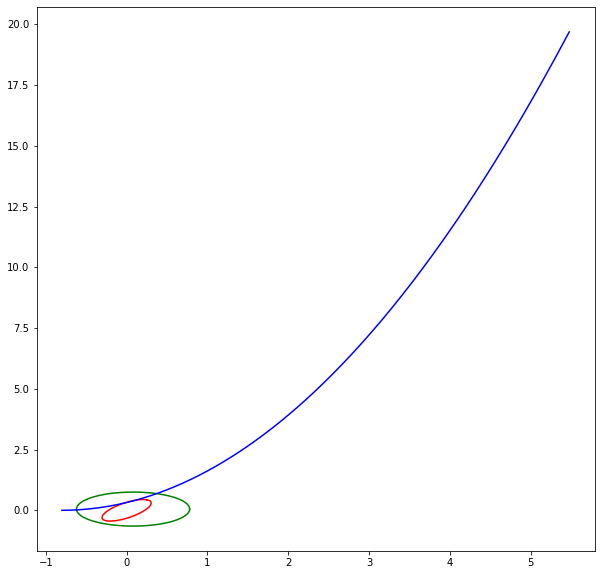

In [2]:

import numpy as np
import matplotlib.pyplot as plt

def ellipse(t, a, b, x0, y0):
    x = x0 + a * np.cos(t)
    y = y0 + b * np.sin(t)
    return x, y

def parabola(t, p, x0, y0):
    x = x0 + t ** 2 / (2. * p)
    y = y0 + t
    return x, y

def rotate(x, y, alpha):
    xr = x * np.cos(alpha) - y * np.sin(alpha)
    yr = x * np.sin(alpha) + y * np.cos(alpha)
    return xr, yr

t = np.arange(0, 2 * math.pi, 0.025)

points = [(), (), ()]

fig1x, fig1y = ellipse(t, figures[0]['a'], figures[0]['b'], figures[0]['x0'], figures[0]['y0'])
points[0] = rotate(fig1x, fig1y, figures[0]['alpha'])

fig2x, fig2y = ellipse(t, figures[1]['a'], figures[1]['b'], figures[1]['x0'], figures[1]['y0'])
points[1] = rotate(fig2x, fig2y, figures[1]['alpha'])

fig3x, fig3y = parabola(t, figures[2]['p'], figures[2]['x0'], figures[2]['y0'])
points[2] = rotate(fig3x, fig3y, figures[2]['alpha'])

figure = plt.figure(figsize = (10, 10))

plt.plot(*points[0], c = 'r')
plt.plot(*points[1], c = 'g')
plt.plot(*points[2], c = 'b')
plt.show()


Создадим датасет на основе полученных точек

In [3]:
datax = np.concatenate((points[0][0], points[1][0], points[2][0]), axis=0)
datay = np.concatenate((points[0][1], points[1][1], points[2][1]), axis=0)


data = np.array([datax, datay])

l1 = [[1, 0, 0] for _ in range(len(fig1x))]
l2 = [[0, 1, 0] for _ in range(len(fig2x))]
l3 = [[0, 0, 1] for _ in range(len(fig3x))]

labels = np.array(l1 + l2 + l3)

data = np.vstack((l1, l2, l3))

data.shape


(756, 3)

Разделим датасет на обучающую и тестовую выборки

In [4]:
train, test, = np.split(data, [int(0.8*len(data))])

X_train = train[:, :2]
y_train = train[:, 2]

X_test = test[:, :2]
y_test = test[:, 2]


Реализуем RBF слой

In [5]:
import keras
import tensorflow as tf
from keras.layers import Layer
from keras import backend as back

class RBF(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBF, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name='mu',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.sigma = self.add_weight(
            name='sigma',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        super(RBF, self).build(input_shape)

    def call(self, inputs):
        diff = back.expand_dims(inputs) - self.mu
        output = back.exp(back.sum(diff**2, axis=1) * self.sigma)
        return output
    

c:\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Создадим и обучим нейросеть

In [6]:
model = keras.models.Sequential([
    RBF(input_dim=2, output_dim=10),
    keras.layers.Dense(3, activation='softmax'),
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics='accuracy'
)

hist = model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=300,
    validation_data=(X_train, y_train),
    shuffle=True,
    verbose=0
)


Посмотрим на график loss

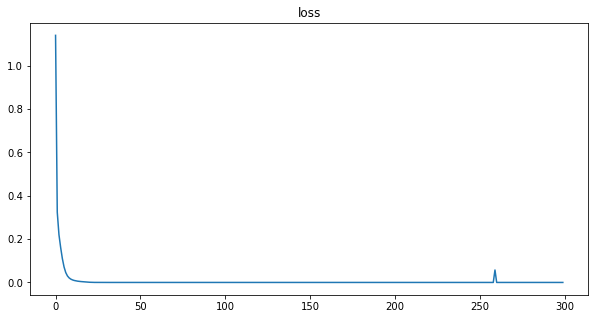

In [7]:
figure = plt.figure(figsize = (10, 5))
histx = []
for i in range(len(hist.history['loss'])):
    histx.append(i)


plt.plot(histx, hist.history['loss'])
plt.title("loss")
plt.show()

Построим классификацию точек

1250/1250 [==============================] - 3s 3ms/step


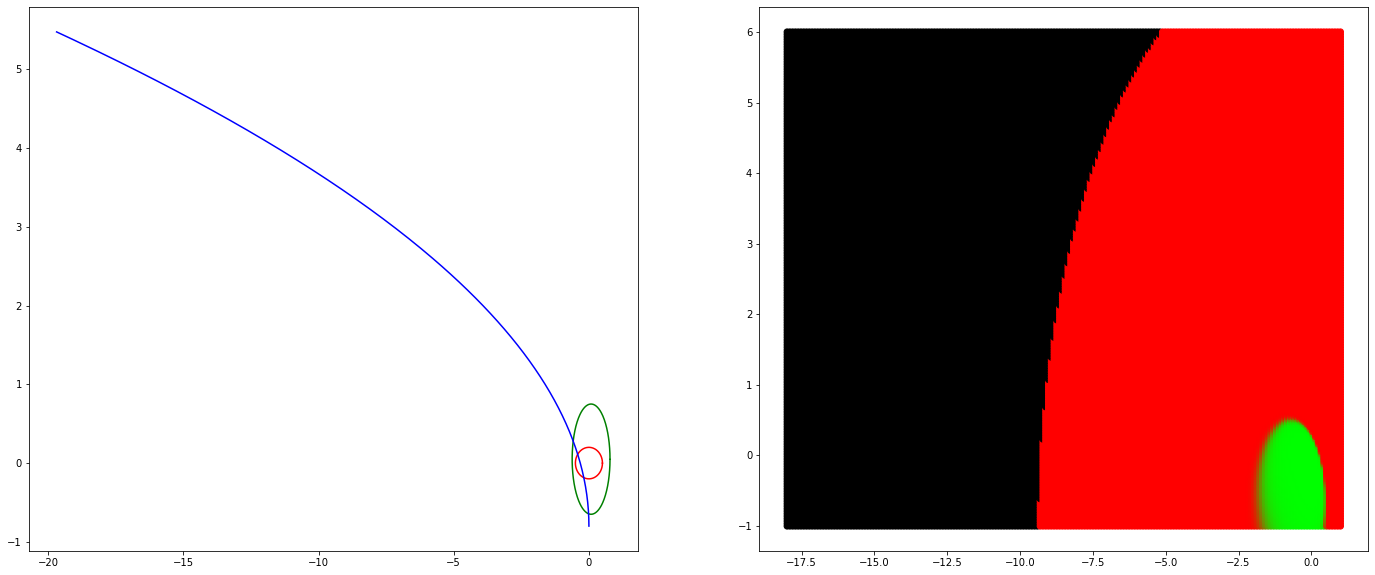

In [8]:
import itertools

x = np.linspace(-18, 1, 200)
y = np.linspace(-1, 6, 200)

figure = plt.figure(figsize = (24, 10))

ax1 = figure.add_subplot(1, 2, 1)
ax2 = figure.add_subplot(1, 2, 2)

ax1.plot(fig1x, fig1y, c = 'r')
ax1.plot(fig2x, fig2y, c = 'g')
ax1.plot(fig3x, fig3y, c = 'b')

data = np.array(list(itertools.product(x, y)))

xy = data.transpose()

pred = model.predict(data)


ax2.scatter(xy[0], xy[1], c = pred)

plt.show()


### Задание 2


In [9]:
def f(t):
    return np.sin(-np.sin(t)*(t**2) + t)

t_range = (0.5, 4)
h = 0.025


На основе заданных функции и промежутка подготовим датасет для обучения, а 
также разделим датасет на обучающую и тестовую выборки

In [10]:
t = np.linspace(t_range[0], t_range[1], int((t_range[1] - t_range[0]) / h))
x = f(t)

train_len = int(t.shape[0] * 0.9)
t_train = t[:train_len]
t_val = t[train_len:]
x_train = x[:train_len]
x_val = x[train_len:]

t_train = np.expand_dims(t_train, 1)
t_val = np.expand_dims(t_val, 1)


Реализуем RBF слой

In [11]:
class RBF(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(RBF, self).__init__(**kwargs)

    def build(self, input_shape):
        self.mu = self.add_weight(
            name='mu',
            shape=(input_shape[1], self.output_dim),
            initializer='uniform',
            trainable=True,
        )

        self.sigma = self.add_weight(
            name='sigma',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        self.sw = self.add_weight(
            name='sw',
            shape=(self.output_dim, ),
            initializer='uniform',
            trainable=True,
        )

        super(RBF, self).build(input_shape)

    def call(self, inputs):
        diff = back.expand_dims(inputs) - self.mu
        output = back.exp(back.sum(diff**2, axis=1) * self.sigma)
        output = output * self.sw
        return output


Создадим и обучим нейросеть

In [12]:
model = keras.Sequential([
    RBF(input_dim=1, output_dim=64),
    keras.layers.Dense(32, activation='tanh'),
    keras.layers.Dense(1),
])

model.compile(loss='mse', optimizer='Adam', metrics=tf.keras.metrics.RootMeanSquaredError())
train_info = model.fit(
    t_train,
    x_train,
    batch_size=4,
    epochs=2000,
    validation_data=(t_val, x_val),
    verbose=0
)


Проверим результаты обучения

4/4 [==============================] - 0s 2ms/step


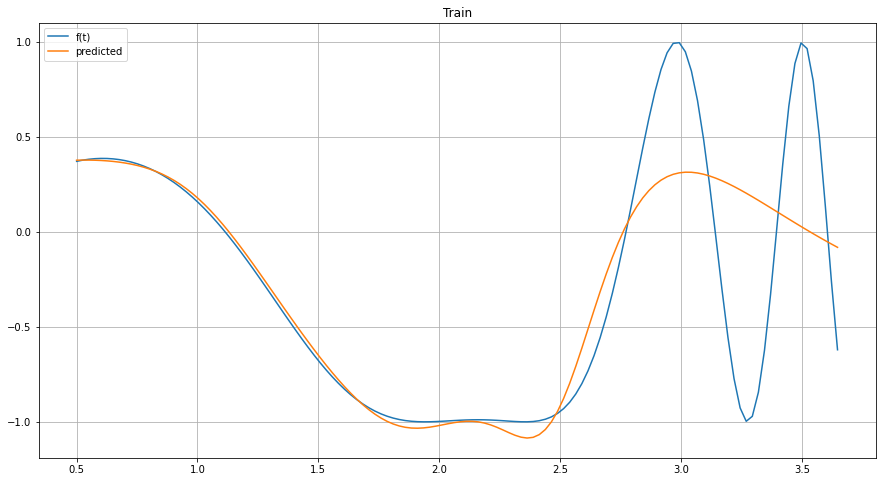

In [13]:
plt.figure(figsize=(15, 8))

plt.plot(t_train, f(t_train), label='f(t)')
plt.plot(t_train, model.predict(t_train), label='predicted')
plt.title('Train')
plt.grid()
plt.legend()
plt.show()

### Выводы

Проделав лабораторную работу, я решил уже знакомые мне задачи, но на этот раз 
самостоятельно реализовал слои для обучения нейросетей и получил некоторые 
результаты.
